In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendp
import math

# Enable opendp features
opendp is still on development mode so to use all the code you must fist.

In [63]:
from opendp.mod import enable_features
enable_features('contrib')

# Histograms

### create dataset

In [20]:
N = 100
number_of_categories = 9
category_propability = [0.002, 0.058, 0.11, 0.15, 0.2, 0.25, 0.15, 0.05, 0.03]
categories = ["A","B","C","D","E","F","G","H","I"]
print("Sum of propabilities:", sum(category_propability))
dataset = np.random.choice(a=categories, p=category_propability, size = N)

Sum of propabilities: 1.0


In [21]:
# count values
labels, counts = np.unique(dataset, return_counts=True)
prop = counts / counts.sum()

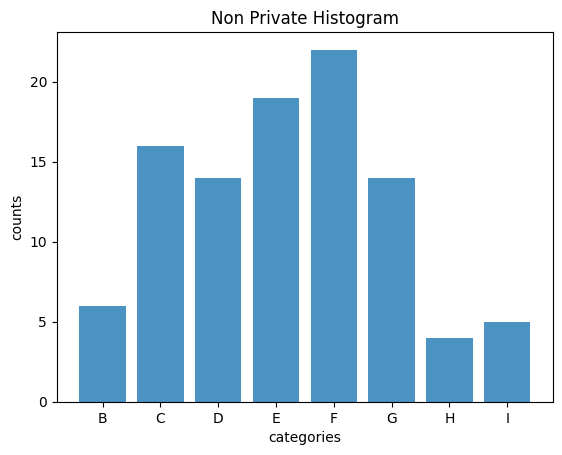

In [22]:
plt.figure()
plt.bar(height = counts, x = labels, alpha = 0.8)
plt.title("Non Private Histogram")
plt.xlabel("categories")
plt.ylabel("counts")
plt.show()
plt.close()

# Differentially Private Histograms
1. split the data in bins
2. count the value to each bin
3. add laplace noise to each bin
4. fix the wrong values

In [23]:
from opendp.meas import make_base_discrete_laplace
from opendp.mod import binary_search, binary_search_chain
from opendp.trans import make_count_by_categories
from opendp.typing import VectorDomain, AllDomain

In [24]:
from opendp.meas import binary_search

In [25]:
histogram = make_count_by_categories(categories=categories)

In [26]:
histogram(dataset)

[0, 6, 16, 14, 19, 22, 14, 4, 5, 0]

In [37]:
noisy_histogram = binary_search_chain(
    lambda s: histogram >> make_base_discrete_laplace(scale=s, D=VectorDomain[AllDomain[int]]),
    d_in = 1,
    d_out = 1.0)

In [38]:
noisy_histogram(dataset)

[-1, 6, 16, 14, 19, 21, 16, 3, 4, -3]

In [39]:
from opendp.trans import make_clamp

In [55]:
noisy_histogram >> make_clamp(bounds = (0, N) )

TypeError: unsupported operand type(s) for >>: 'Measurement' and 'Transformation'

In [64]:
from opendp.comb import *

In [65]:
make_chain_tm(noisy_histogram,make_clamp(bounds = (0, N)))

NameError: name 'make_chain_tm' is not defined

In [41]:
make_clamp(bounds = (0, N) )([-1, 6, 16, 14, 19, 21, 16, 3, 4, -3])

[0, 6, 16, 14, 19, 21, 16, 3, 4, 0]

In [53]:
hist = np.array(histogram(dataset))
private_hist = np.array(noisy_histogram(dataset))

In [54]:
np.abs(hist/hist.sum() - private_hist/private_hist.sum()).sum()

0.10212765957446804

# Laplace Mechanism example

### Discrete Laplace Mechanism

Lets check is our mechanism is correct.  
We will first check the theoritical results

In [15]:
from opendp.meas import make_base_discrete_laplace

epsilon = 1.0 
sensitivity = 10
l = sensitivity / epsilon
print(f"Laplcacian scale λ : {l}")

Laplcacian scale λ : 10.0


In [16]:
# call the constructor to produce a measurement
discrete_laplace_mechanism = make_base_discrete_laplace(scale=l, D=AllDomain[int])

In [17]:
# you can get espilon of your laplcasian mechanism if you specify the sensitiviy
get_epsilon = discrete_laplace_mechanism.map(d_in=sensitivity)

In [18]:
# investigate the privacy relation
is_private = discrete_laplace_mechanism.check(d_in=sensitivity, d_out=epsilon)
print(is_private)

True


In [19]:
l_tmp = l - 1

# call the constructor to produce a measurement
discrete_laplace_mechanism = make_base_discrete_laplace(scale=l_tmp)

# investigate the privacy relation
is_private = discrete_laplace_mechanism.check(d_in=sensitivity, d_out=epsilon)
print(is_private)

False


### make a private release

In [20]:
some_non_private_data = 5
private_release = discrete_laplace_mechanism(some_non_private_data)
private_release

2

In [21]:
some_non_private_data = [5,5,5,5]
private_release = [discrete_laplace_mechanism(datum) for datum in some_non_private_data]
private_release

[-2, -7, 21, 17]

In [23]:
private_release = discrete_laplace_mechanism(some_non_private_data)
private_release

TypeError: inferred type is Vec<i32>, expected i32. See https://github.com/opendp/opendp/discussions/298

# Typing

now lets aplay a mechanism whit less noise that the theoritical results

In [24]:
from opendp.typing import VectorDomain
vectorized_discrete_laplace_mechanism = make_base_discrete_laplace(scale=l, D=VectorDomain[AllDomain[int]])

In [25]:
some_large_dataset = [5]*100
%timeit vectorized_discrete_laplace_mechanism(some_large_dataset)

701 µs ± 7.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [26]:
some_large_dataset = [5]*100
%timeit [discrete_laplace_mechanism(datum) for datum in some_large_dataset]

4.01 ms ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Continius Laplace Mechanism

In [27]:
from opendp.meas import make_base_laplace
# enable floating points if you want contrinius laplacian mechanism
enable_features("floating-point")

In [28]:
epsilon = 1.0 
sensitivity = 10.2
l = (sensitivity / epsilon)

# call the constructor to produce a measurement
laplace_mechanism = make_base_laplace(scale=l, D=VectorDomain[AllDomain[float]])

In [29]:
epsilon_2 = 0.5 
sensitivity_2 = 10.2
l_2 = (sensitivity_2 / epsilon_2)

# call the constructor to produce a measurement
laplace_mechanism_2 = make_base_laplace(scale=l_2, D=VectorDomain[AllDomain[float]])

In [33]:
some_non_private_input = [0.0]*1000
private_release = laplace_mechanism(some_non_private_input)
private_release_2 = laplace_mechanism_2(some_non_private_input)

In [34]:
import seaborn as sns

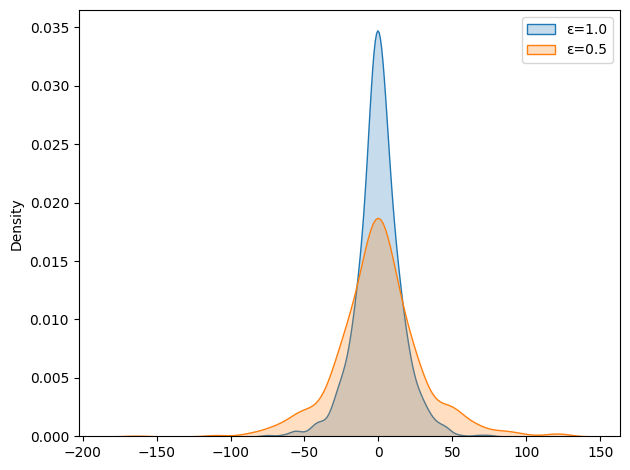

In [36]:
fig, ax = plt.subplots()
sns.kdeplot(private_release,label = f"ε={epsilon}",ax=ax,fill=True)
sns.kdeplot(private_release_2,label = f"ε={epsilon_2}",ax=ax,fill=True)
ax.legend()
plt.tight_layout()
plt.show()

# last week example

In [37]:
def logsequence(start, stop, num, base=10, decimals=2, asint=False):
    my_seq = np.linspace(start=math.log10(start), stop=math.log10(stop), num=num)
    my_seq = np.power(10, my_seq)
    if asint:
        my_seq = list(my_seq.round().astype(int))
    else:
        my_seq = my_seq.round(decimals=decimals)
    return my_seq

N_seq = logsequence(start=50, stop=800, num=8, asint=True)
epsilon_seq = logsequence(start=100, stop=0.01, num=4, decimals=2) 

In [38]:
print("Sequence of dataset sizes:  " + str(N_seq))
print("Sequence of epsilon values: " + str(epsilon_seq))

Sequence of dataset sizes:  [50, 74, 110, 164, 244, 362, 538, 800]
Sequence of epsilon values: [1.00e+02 4.64e+00 2.20e-01 1.00e-02]


# global privacy

In [39]:
def global_private_average(epsilon, data, domain_range):
    """
    implementation of the global private model of average function
    """
    N = data.shape[0]
    
    # 0. calulate average
    average = np.mean(data)
    
    # 1. create laplace mechanism
    sensitivity = domain_range/N
    l = (sensitivity / epsilon)
    laplace_mechanism = make_base_laplace(scale=l)
    
    # 2. calculate private release
    private_average = laplace_mechanism(average)
    
    return private_average

In [51]:
lower_value_x = 0
upper_value_x = 10

error_per_dataset = []
for N in N_seq:
    
    # generate data
    data_tmp = np.random.uniform(low = lower_value_x, 
                                 high = upper_value_x, 
                                 size = N)
    
    # average groundtruth
    average_value = np.mean(data_tmp)
    
    # create differential private release for different epsilon
    avg_error = []
    for epsilon in epsilon_seq:
        
        error_tmp = []
        # calculate error k times to get the average error
        for i in range(100):
            private_release = global_private_average(epsilon = epsilon,
                                                     data = data_tmp,
                                                     domain_range = upper_value_x - lower_value_x)
            error = abs(average_value-private_release)
            error_tmp += [error]
            
        avg_error += [np.mean(error_tmp)]
        
    error_per_dataset += [avg_error]

In [52]:
error_results = pd.DataFrame(error_per_dataset , columns = epsilon_seq, index = N_seq)

Text(0, 0.5, 'Absolute error')

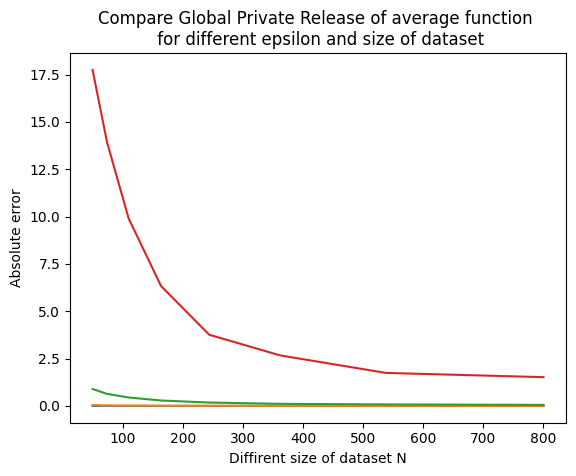

In [53]:
for e in error_results.columns:
    plt.plot(N_seq,error_results[e])
plt.title("Compare Global Private Release of average function \n for different epsilon and size of dataset")
plt.xlabel("Diffirent size of dataset N")
plt.ylabel("Absolute error")

Text(0, 0.5, 'log absolute error')

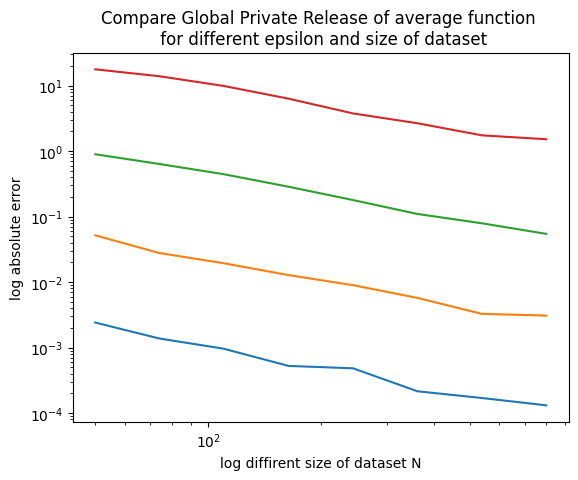

In [54]:
fig1, ax1 = plt.subplots()
for e in error_results.columns:
    plt.loglog(N_seq, error_results[e])
# ax1.set_xticks(N_seq)
plt.title("Compare Global Private Release of average function \n for different epsilon and size of dataset")
plt.xlabel("log diffirent size of dataset N")
plt.ylabel("log absolute error")

# 2. local privacy

In [55]:
def local_private_average(epsilon, data, domain_range):
    """
    implementation of the local private model of average function
    """
    N = data.shape[0]
    
    # 1. create laplace mechanism
    sensitivity = domain_range/N
    l = (sensitivity / epsilon)
    laplace_mechanism = make_base_laplace(scale=l, D=VectorDomain[AllDomain[float]])
    
    # 2. calculate private release
    private_dataset = laplace_mechanism(data)
    
    # 3. calulate average
    private_average = np.mean(private_dataset)
    
    return private_average

In [59]:
lower_value_x = 0
upper_value_x = 10

error_per_dataset = []
for N in N_seq:
    # generate data
    data_tmp = np.random.uniform(low = lower_value_x, 
                                 high = upper_value_x, 
                                 size = N)
    # average groundtruth
    average_value = np.mean(data_tmp)
    
    # create differential private release for different epsilon
    avg_error = []
    for epsilon in epsilon_seq:
            
        error_tmp = []
        # calculate error k times to get the average error
        for i in range(50):
            private_release = local_private_average(epsilon=epsilon,
                                                    data=data_tmp,
                                                    domain_range=upper_value_x-lower_value_x)
            error = abs(average_value-private_release)
            error_tmp += [error]
            
        avg_error += [np.mean(error_tmp)]
        
    error_per_dataset += [avg_error]

In [60]:
local_error_results = pd.DataFrame(error_per_dataset , columns = epsilon_seq, index = N_seq)

Text(0, 0.5, 'log absolute error')

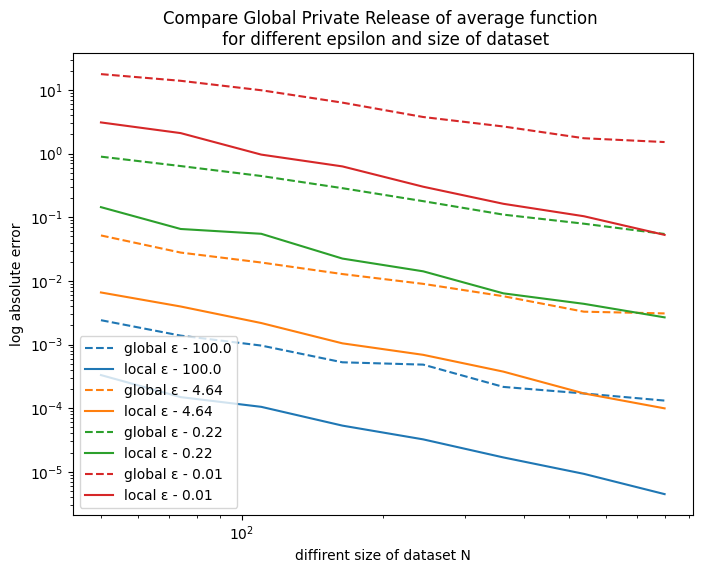

In [61]:
fig1, ax1 = plt.subplots(figsize = (8,6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i,e in enumerate(error_results.columns):
    plt.loglog(N_seq, error_results[e], "--",color=colors[i], label = f"global ε - {e}")
    plt.loglog(N_seq, local_error_results[e],color=colors[i], label = f"local ε - {e}")
# ax1.set_xticks(N_seq)
plt.legend()
plt.title("Compare Global Private Release of average function \n for different epsilon and size of dataset")
plt.xlabel("diffirent size of dataset N")
plt.ylabel("log absolute error")